In [39]:
import streamlit as st
import os
import google.generativeai as genai
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAI
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import create_retrieval_chain
from langchain_community.vectorstores import FAISS
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from dotenv import load_dotenv
import pandas as pd
import time
import json
import s3fs
import shutil
import glob
from sagemaker.s3 import S3Downloader
from pathlib import Path 
from PIL import Image

In [3]:
load_dotenv()
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
embeddings = GoogleGenerativeAIEmbeddings(model = "models/embedding-001")
llm        = ChatGoogleGenerativeAI(model="gemini-pro", temperature=0)

In [11]:
temp_dir  = "../artifacts/temp/"
image_dir = "s3://amazon-berkeley-objects/images/small/"
json_file = pd.read_json("../artifacts/dataset.json")
vector_db = FAISS.load_local("../artifacts/FAISS_DB", embeddings, allow_dangerous_deserialization=True)

In [12]:
prompt    = ChatPromptTemplate.from_template(
"""
You are a Helpful sales recommender who will have a casual and friendly chat with the buyer to find out what they are looking for.
Always introduce yourself as "ShopChat recommender" but Instead of asking directly what kind of products they are looking for, 
have a casual conversation to understanding the need of the buyer. Don't start the conversation like a salesperson. 
When you are confident that you have enough information, recommend the product to the buyer. You also return possible recommendations 
when you are not fully confident but somewhat confident. 

You will always respond in the JSON schema presented below, always return all fields:

{{
    "your_reasoning": "string", # This is where you think out loud and explain your reasoning for the recommendation, this is only for you
    "confidence": "string", # This is where you explain how confident you are in your recommendation, this is only for you, can be low, medium, high
    "recommendation": "list", # This is where you recommend a list of the products to the buyer, only return if your confidence is medium or high. this can only be the name of the product and nothing else. if you are at medium or high confidence always return a recommendation
    "your_response_to_buyer": "string" # This is where you respond to the buyer, this is what the buyer will see. Only recommend the product to the user in this response as list of products if your confidence is high. Always have a response for the user in all cases
    "item_id": # This is where you will add the list of "item_id" from the context documents for the recomanded products.
    "domain_name": # This is where you will add the list of "domain_name" from the context documents for the recomanded products.
    "image_id": # This is where you will add the list of "path" from the context documents for the recomanded products.
}}

Here are the products in stock with Amazon:

Answer the questions based on the provided context only, do not make it up if not in context documents.

<context>
{context}
<context>
Questions:{input}

"""
)

In [36]:
def get_image(image_path):
    
    s3_path    = image_dir + image_path
    image_file = Path(image_path).name
    temp_path  = temp_dir + image_file

    S3Downloader.download(s3_path, temp_dir)
    #image_pil  = Image.open(temp_path)

    return temp_path

In [40]:
files = glob.glob(temp_dir + '*')
for f in files:
    os.remove(f)

In [13]:
query   = "Can you please suggest some red chairs?"

In [14]:
document_chain=create_stuff_documents_chain(llm,prompt)
retriever=vector_db.as_retriever()
retrieval_chain=create_retrieval_chain(retriever,document_chain)
start=time.process_time()
response=retrieval_chain.invoke({'input':query})
json_response = json.loads(response['answer'])

print("Response time :",time.process_time()-start)
print(json_response['your_response_to_buyer'])

Response time : 0.08465400000000045
I see you are looking for red chairs, here are a few options that we have in stock on Amazon:

1. Amazon Brand – Rivet Florence Mid-Century Wide Open-Back Accent Dining Room Chairs, 18.8"W, Red, Set of 2
2. Amazon Brand – Rivet Federal Mid-Century Modern Wood Dining Kitchen Chairs, Upholstered, Set of 2, Red
3. Amazon Brand – Rivet Brianna Mid-Century 2-Pack Removable Cushion Chairs, 34.2"H, Red


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

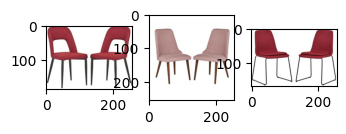

In [37]:
i=1
for item_id, domain_name, image_id in zip(json_response["item_id"], json_response["domain_name"], json_response["image_id"]):
    temp_path = get_image(image_id)
    image_pil = Image.open(temp_path).convert('RGB')
    image_pil.resize((300,300))
    plt.subplot(1, 5, i)
    plt.imshow(image_pil)
    i+=1

More Images
Click the link to buy:  https://www.amazon.com/dp/B075YPTG6M


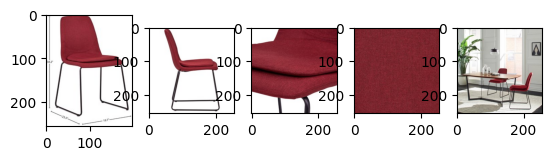

In [38]:
print("More Images")
more_images_paths = json_file[json_file["item_id"] == item_id]["other_image_id_path"].to_list()[0]
more_images = []
for more_images_path in more_images_paths:
    temp_path = get_image(more_images_path)
    image_pil = Image.open(temp_path).convert('RGB')
    image_pil.resize((100,100))
    more_images.append(image_pil)
total = len(more_images)
for i, images in enumerate(more_images):
    plt.subplot(1, total, i+1)
    plt.imshow(images)
print("Click the link to buy:  https://www." + domain_name + "/dp/" + item_id)

In [25]:
more_images

[<PIL.Image.Image image mode=RGB size=196x256>,
 <PIL.Image.Image image mode=RGB size=256x256>,
 <PIL.Image.Image image mode=RGB size=256x256>,
 <PIL.Image.Image image mode=RGB size=256x256>,
 <PIL.Image.Image image mode=RGB size=256x256>]